### MLP

Problem with the previous model, where we had only 1 layer of 28 neurons was that, \
Since, we were looking at one one previous character, the name generations were not very convincing

The problem with the tabular probabitlities in the model was scalability.

Since, we were looking at only 1 previous character, we had only 28 probabilities per character.\
If we wish to look into 2 previous characters to predict the next, then the number of probabilities and hence the rows in the table would be 28*28 = 784.

The number of columns will still remain the same (denoting the next character) but the rows will be 784 now, denoting the possible combinations of 2 previous characters.

If we wish to consider 3 previous characters, then the number of rows would become `28^3 = approx. 20000`

Also note, that the matrix of probabilities would be a **sparse matrix** as typical names would not have all the possible combinations of 2 characters.

Hence we will stick to the neural network building and make it more complex by having a **Multi Layer Perceptron**


### Taking inspiration from Bengio et al. 2003

The paper **[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)** proposes a language model that works on words; we are working on a character-level language model, taking inspiration from the same model.

The paper discusses representing each word from the entire vocabulary of 17,000 words in a 30-dimensional space. \
Initially, these points (word embeddings) are spread out in the space at random, and then tuned using back-propagation in such a way that words with similar meanings or which are related to each other in some way end up staying close to each other, and conversely, the words with different meanings would end up being distant from each other.

Similar to the paper, we are also using a Multi-Layer Neural Network to predict the next character given the sequence of previous characters, and to train the neural network, they are maximising the Log-Likelihood of the training data, such that similar occurring characters would be placed close to each other in the newly created vector space.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

import pickle

In [3]:
# read all the cleaned names 
with open('indian_names_clean.pkl', 'rb') as f:
    names = pickle.load(f)

print(f"Ready! Loaded {len(names)} names")
print("First 10:", names[:10])

Ready! Loaded 64128 names
First 10: ['jyotirmoy', 'ilamuhil', 'indravathi', 'raamen', 'benudhar', 'mithushaya', 'malani', 'sathuna', 'oviyashri', 'vaitheeswarsn']


In [7]:
# build the vocabulary of characters and lookup tables
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

print(stoi)
print(itos)

{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


### Building the Neural Network
Taking reference from the paper 
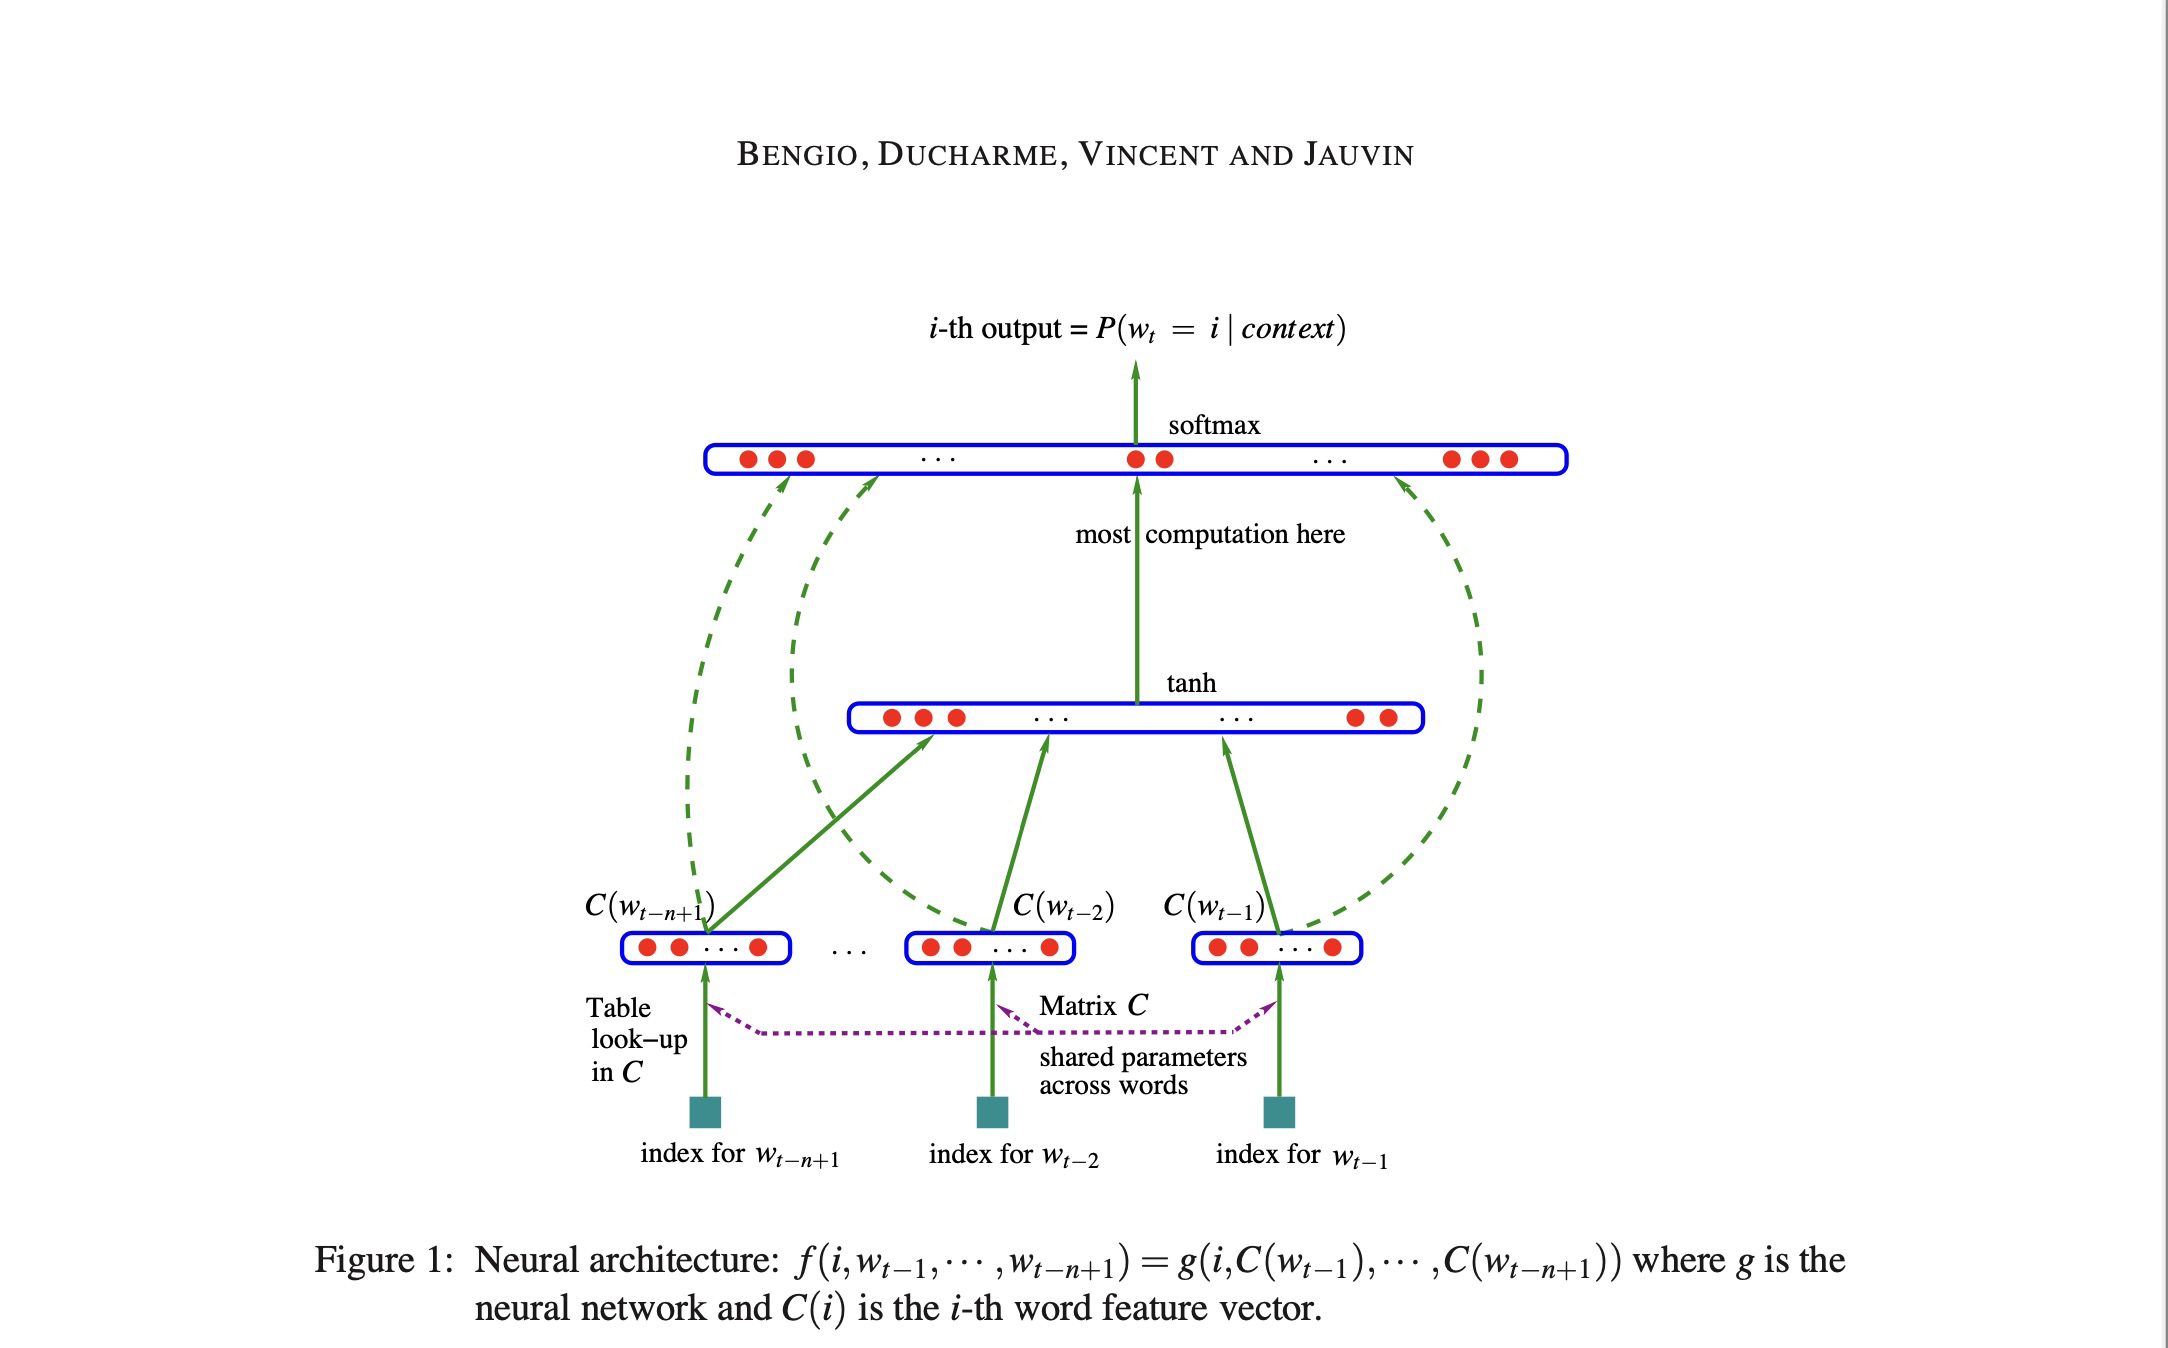

The neural network takes 3 input words (in our case, we will take 3 input characters) to predict the 4th word (character).

In [24]:
# build the dataset for the neural network
block_size = 3 # context length for a 4-gram character level language model : we are taking previous 3 characters to predict the 4th one
X, Y = [], []

for name in names[:2]:
    print(name)
    context = [0] * block_size
    for ch in name + '.':
        index = stoi[ch]
        X.append(context)
        Y.append(index)
        print(''.join(itos[i] for i in context), '---->', itos[index])
        context = context[1:] + [index]    # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


jyotirmoy
... ----> j
..j ----> y
.jy ----> o
jyo ----> t
yot ----> i
oti ----> r
tir ----> m
irm ----> o
rmo ----> y
moy ----> .
ilamuhil
... ----> i
..i ----> l
.il ----> a
ila ----> m
lam ----> u
amu ----> h
muh ----> i
uhi ----> l
hil ----> .


In [27]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([19, 3]), torch.int64, torch.Size([19]), torch.int64)

### Building Lookup Table (C)

`{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}`

We have 28 possible characters and we are going to embed them in a lower dimensional space (In the paper they have 17000 words and they embedded them in dimensions as small as 30). In our case, lets try to start embedding the 28 characters in a 2-D space.

Let's build the lookup table comprising of 28 rows denoting each 28 characters and 2 columns having 2 features per character.

In [29]:
C = torch.randn((28,2))

Before embedding each character into the 2 dimensional space using C, lets first try to embed a single interger to this space, to see how this embedding works

One way to do it, is by directly pointing to the 5th row of the lookup table, C

In [30]:
C[5]

tensor([-0.6343,  1.3699])

Another way of achieving this is the way we did for `build_makemore_nn`, which is seemingly different but actually identical method.\
Using the **One Hot Encoding** Method.

Here, we will get a vector whose 5th dimension is activated (1) and it has a length of 28 

In [33]:
F.one_hot(torch.tensor(5), num_classes=28)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [34]:
F.one_hot(torch.tensor(5), num_classes=28).shape

torch.Size([28])

### Seemingly Different but actually same

The reason why one-hot encoding is same as C[5] -> If you notice, \
the one-hot encoding of 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

When we multiply this vector with C - since only the 5th dimension of the above vector is 1, it will only give the 5th row of C\
because `the one-hot encoding of 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is a `[1 * 28]` matrix and C is a `[28 * 2]` matrix \
Therefore, their multiplication with give `[1 * 2]` row vector which is just the 5th row of C.

In [36]:
C[5]

tensor([-0.6343,  1.3699])

In [35]:
F.one_hot(torch.tensor(5), num_classes=28).float() @ C

tensor([-0.6343,  1.3699])

### Word Embedding Lookup via One-Hot Multiplication

Let e = [0, 0, 0, 0, 0, 1, 0, ..., 0] (1 at position 5) - One-hot encoding of 5 \
C is [28 * 2] lookup table, a matrix with 28 rows corresponding to all 28 distinct characters of our dataset, and 2 columns storing the 2 features of each character.

The operation `e @ C` (where e is a one-hot vector of length 28 with a 1 at index 5, and C is a 28×2 matrix) simply selects the 5th row of C (0-based indexing, so row index 5).

**A one-hot vector acts like a selector: it has zeros everywhere except a single 1.**\
Matrix multiplication with a one-hot row vector picks out the corresponding row from the matrix.

The first layer of the massive neural network could be treated as just indexing into the matrix `C` as it would be faster compared to the operation `e @ C`

In [38]:
X

tensor([[ 0,  0,  0],
        [ 0,  0, 11],
        [ 0, 11, 26],
        [11, 26, 16],
        [26, 16, 21],
        [16, 21, 10],
        [21, 10, 19],
        [10, 19, 14],
        [19, 14, 16],
        [14, 16, 26],
        [ 0,  0,  0],
        [ 0,  0, 10],
        [ 0, 10, 13],
        [10, 13,  2],
        [13,  2, 14],
        [ 2, 14, 22],
        [14, 22,  9],
        [22,  9, 10],
        [ 9, 10, 13]])

In [37]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([19, 3]), torch.int64, torch.Size([19]), torch.int64)

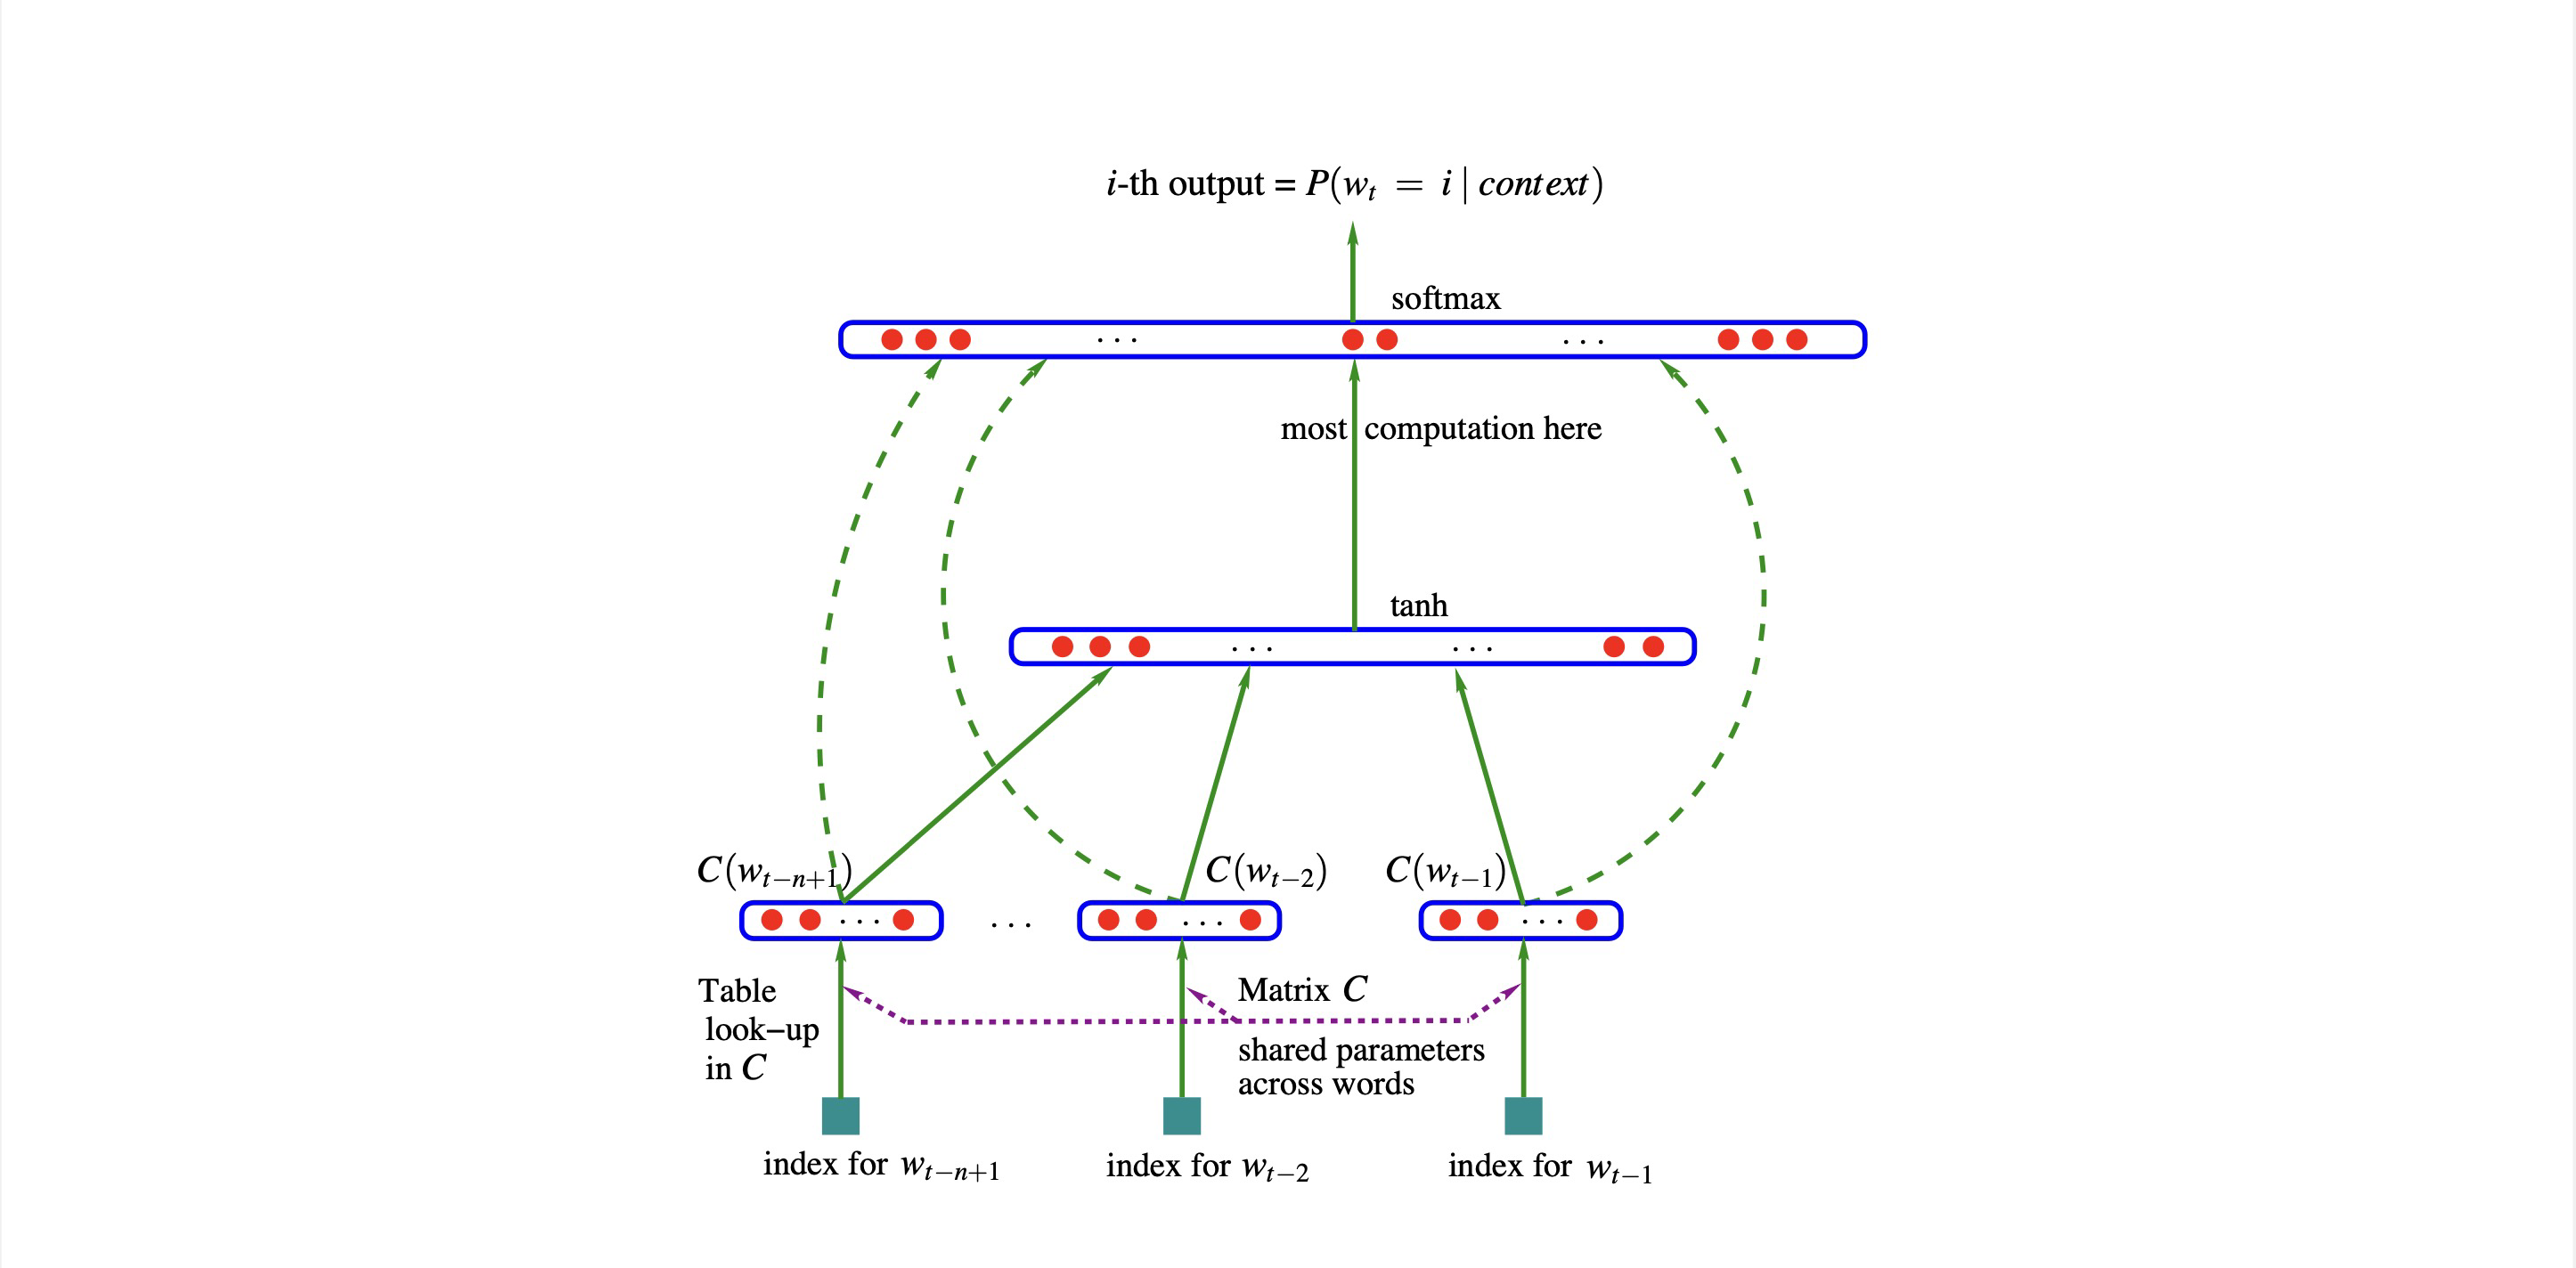

From the image above, the 3 columns of each row of X will go to 3 look ups simultaneously as X holds the 3 previous characters

X[0,0] = index for $w_{t-n+1}$\
X[0,1] = index for $w_{t-2}$\
X[0,2] = index for $w_{t-1}$

Looking up (embedding) just one interger (like 5 above) was easy as it was a direct lookup (`C[5]`)
How do we simultaneously look up the entire [19 x 3] integers as seen above from X.shape?

### Pytorch Indexing
Pytorch provides a powerful indexing technique where we can index specific rows using lists: \
example: 
* C[[5,6,7]] will give the 5th, 6th and 7th row of C
* We can also use tensor: C[([5,6,7])]
* We can repeat a row multiple times as well C[([7,7,7,7,7,7,7])]



In [53]:
print(C[5])
print(C[6])
print(C[7])
print(C[[5,6,7]])
print(C[([5,6,7])])
print(C[([7,7,7,7,7,7,7])])

tensor([-0.6343,  1.3699])
tensor([-2.2420,  0.7920])
tensor([-0.3851, -1.3634])
tensor([[-0.6343,  1.3699],
        [-2.2420,  0.7920],
        [-0.3851, -1.3634]])
tensor([[-0.6343,  1.3699],
        [-2.2420,  0.7920],
        [-0.3851, -1.3634]])
tensor([[-0.3851, -1.3634],
        [-0.3851, -1.3634],
        [-0.3851, -1.3634],
        [-0.3851, -1.3634],
        [-0.3851, -1.3634],
        [-0.3851, -1.3634],
        [-0.3851, -1.3634]])


The above was for retrieving 1-D tensors

We can also retrieve multi dimensions embeddings from C

In [60]:
X.shape

torch.Size([19, 3])

In [61]:
C.shape

torch.Size([28, 2])

In [55]:
C[X].shape

torch.Size([19, 3, 2])

In the above retrieval, we see the shape of C[X] as [19 * 3 * 2] -> 
* 19 are the rows of X
* 3 are the 3 consecutive characters
* 2 are the features of each character

To understand this better:
X[13,2] should be the $w_{t-2}$ character for 13th character in Y (Y[13])
so, C[X[13,2]] should be equal to C[index], where index is the result of X[13,2]

To visualize:
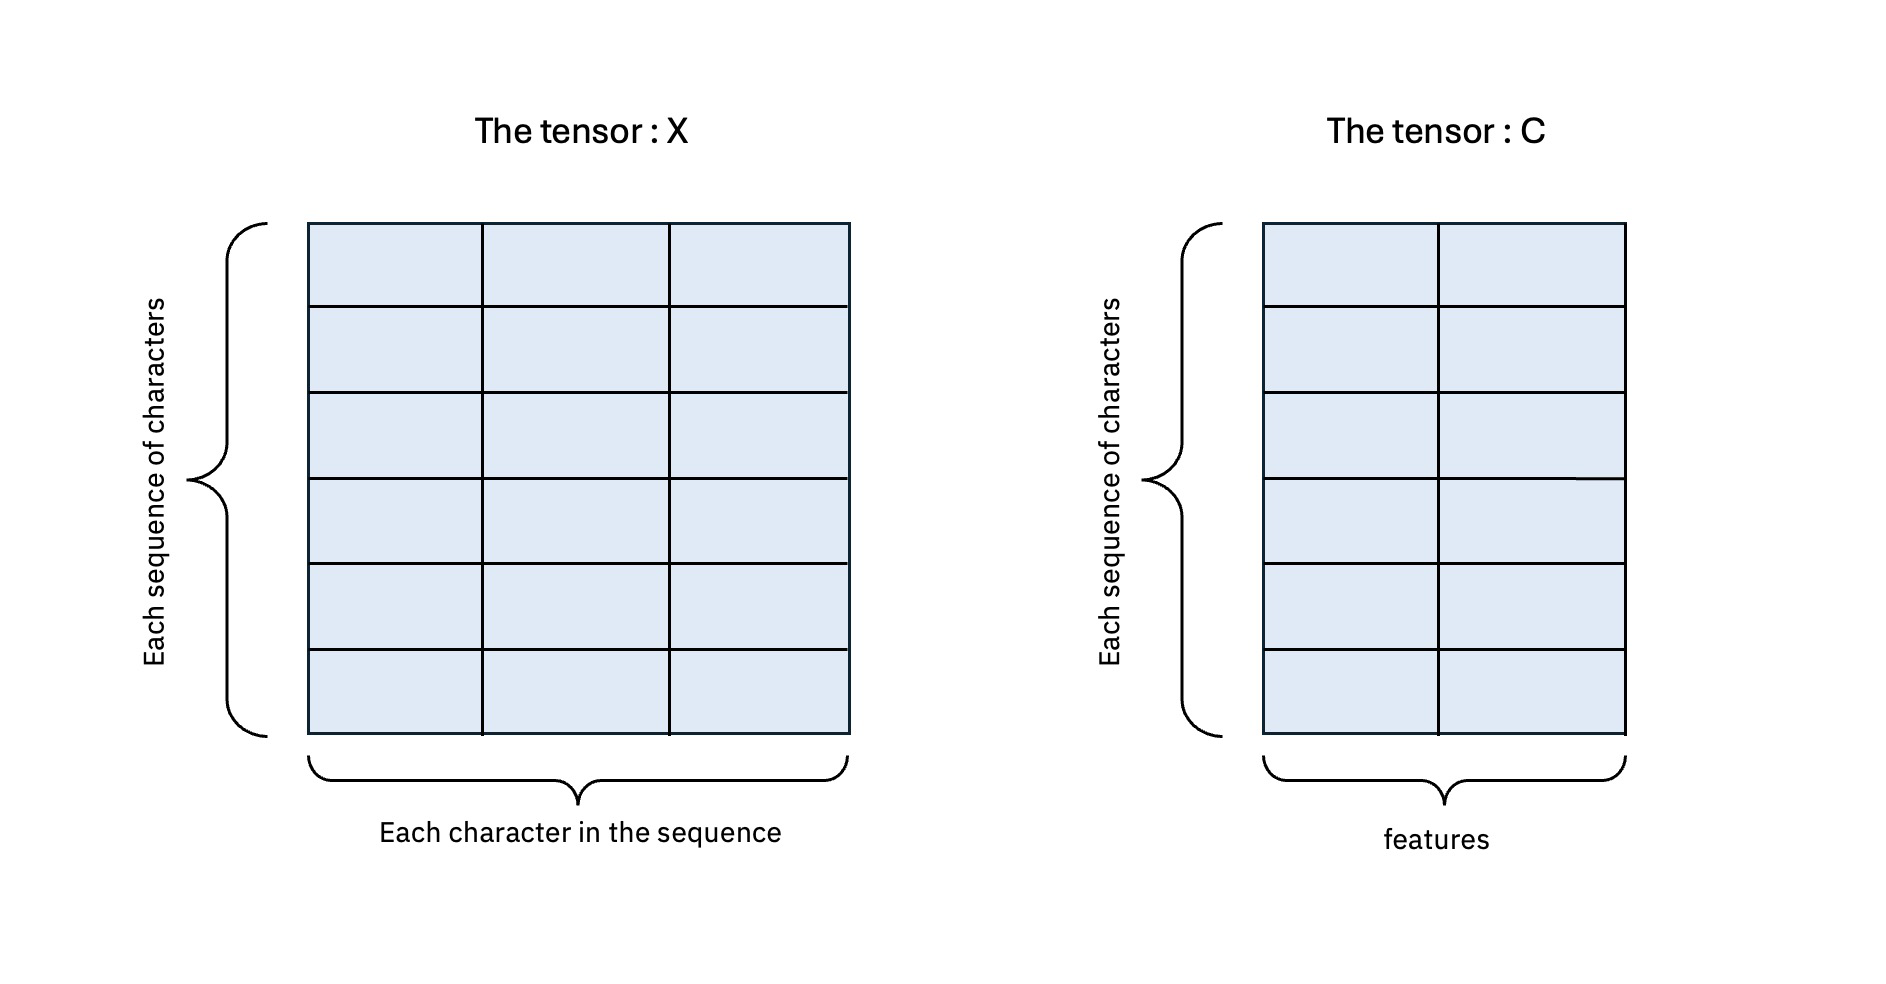

Then C[X] will look like below:
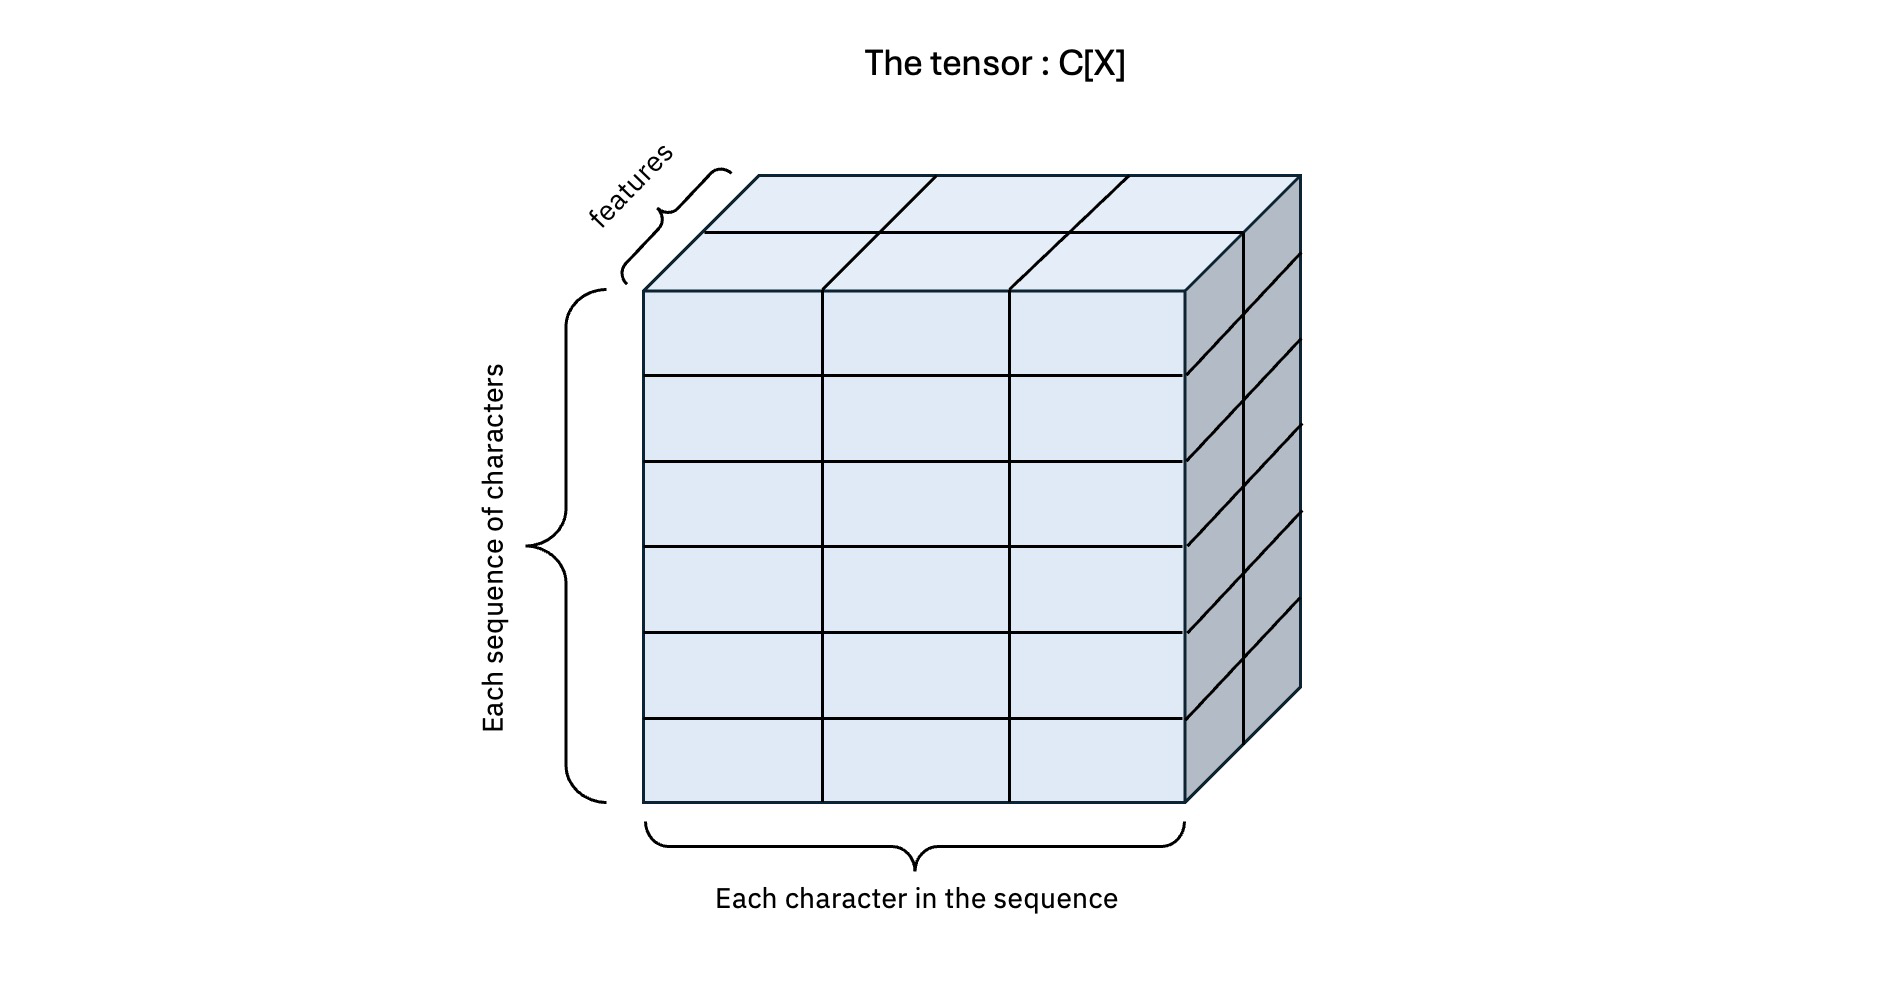

In [56]:
print(X[13,2])
print(C[X[13,2]])

tensor(2)
tensor([-0.4475, -0.8111])


In [57]:
C[2]

tensor([-0.4475, -0.8111])

### The first layer of NN
Creating the first layer of the neural network - A mapping of each sequence to the lookup table

In [62]:
# Creating the embedding
emb = C[X]
emb.shape

torch.Size([19, 3, 2])

### Creating the Hidden Layer
```
Number of inputs to the hidden layer = Total number of outputs from the first layer 
Total number of outputs from the first layer = Total number of characters in our sequence * number of features of each character
                                             = 3 * 2 = 6
```

In [64]:
W1 = torch.randn((6, 100))   # 100 are the number of neurons in the hidden layer (we can choose it however)
b1 = torch.randn(100)       # 100 biases for the 100 neurons

### Forward Pass for the Hidden Layer

Generally we would do: `emb @ W1 + b1` \
but here, we cannot do that as the size of matrices do not match

In [65]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (57x2 and 6x100)

### Unwrapping the C[X] 
In order to perform the forward pass through the hidden layer of 100 neuron, we will unwrap the C[X] embeddings as shown below:

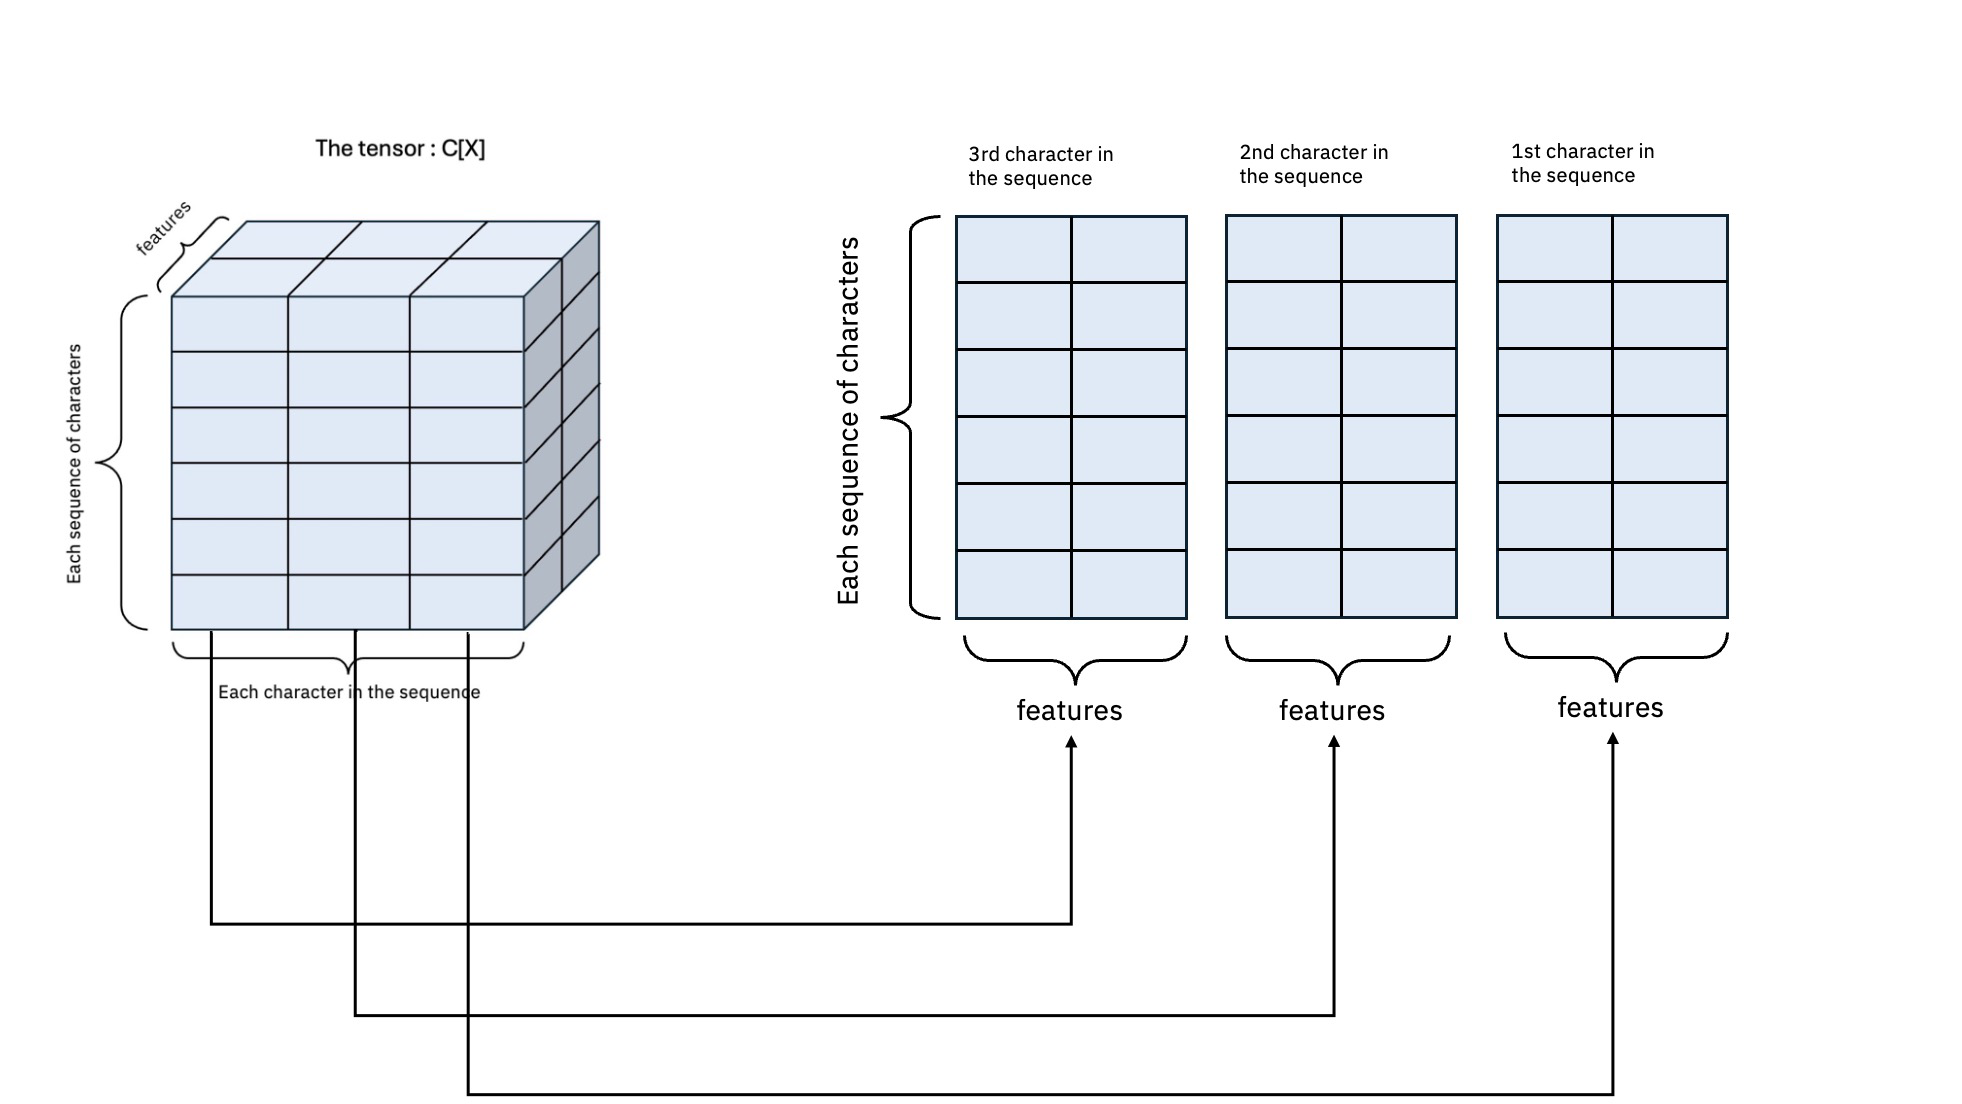

Instead of sending a [1 * 3 * 2] tensor to the hidden layer (one row from C[X]), we will now send a single row with 6 features like below:

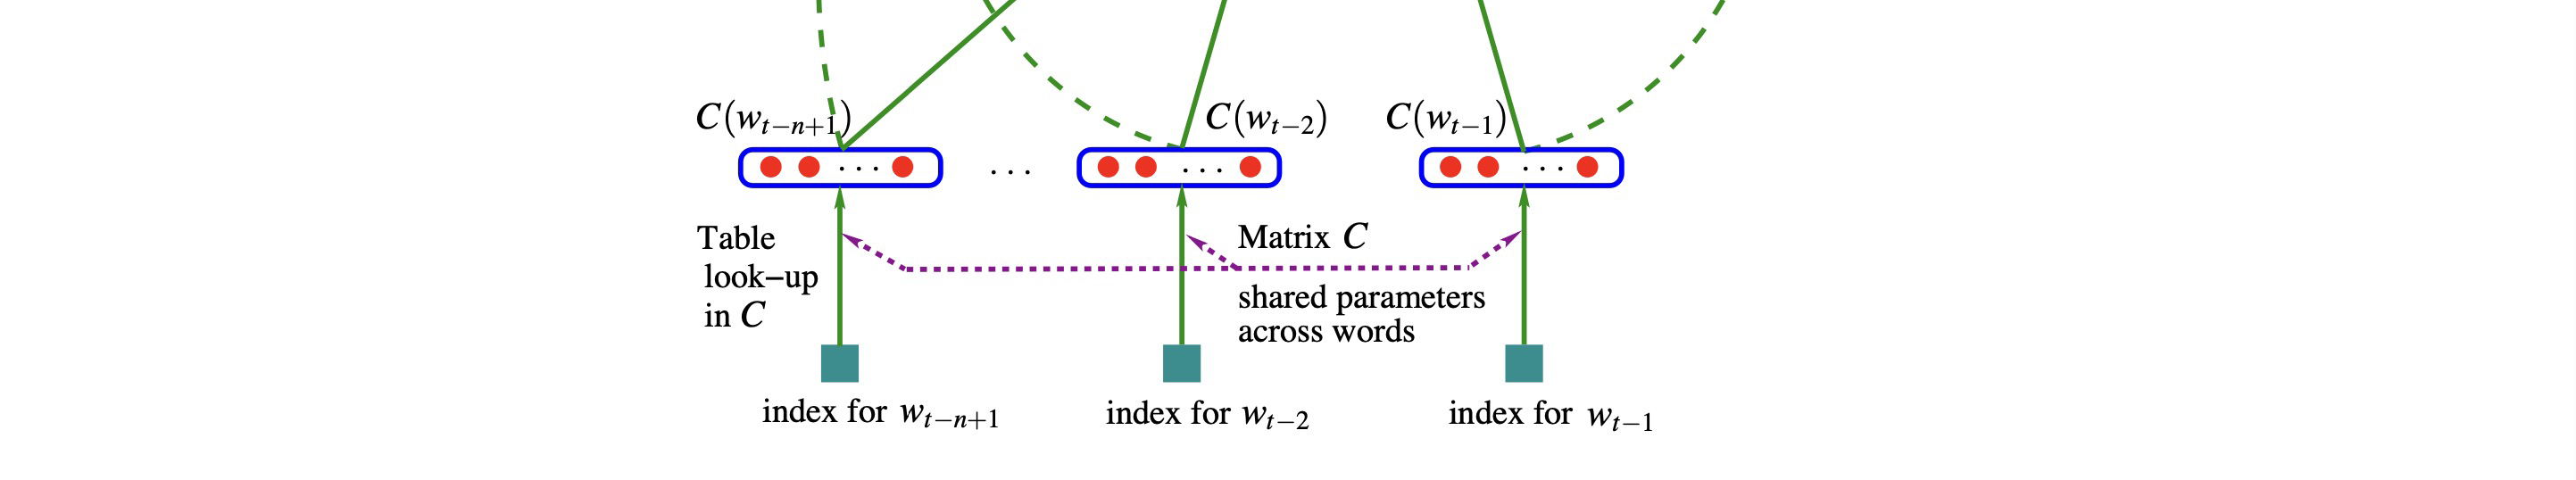

Here we have unwrapped each character as its own feature set and concatenated one after the other

In [66]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([19, 6])

The result above shows that each input sequence has been unwrapped in such a way that each character sequence is now the sequence of the features:

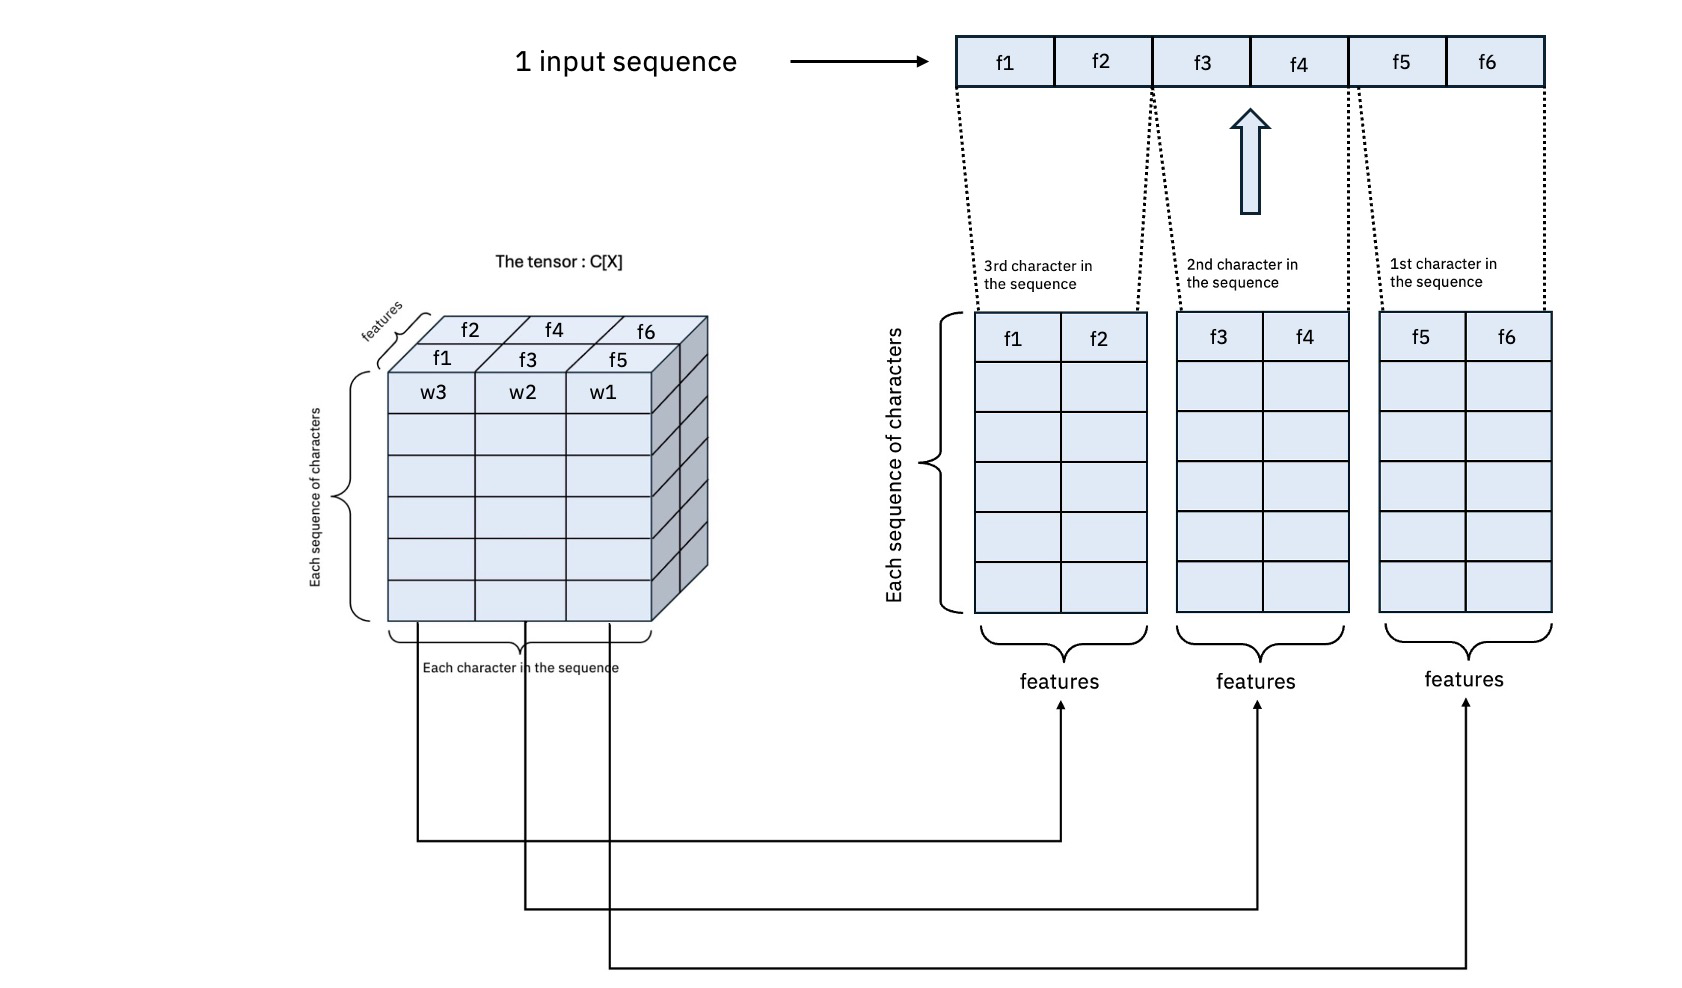

In [73]:
# Generalizing the above: -> [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]
len(torch.unbind(emb, 1))

3

In [74]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([19, 6])

### Better & Efficient Way
There is a significantly better and efficient way to achieve the above.

In pytorch, `.view()` function is a very efficient function.

Lets see that by an example:

In [77]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [76]:
a.shape

torch.Size([18])

In [78]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [79]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [82]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [85]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

### View Function
Why is it so efficient?

In each tensor, their is an underlying storage(), which is always all the numbers as a 1 dimensional vector.\
pytorch uses, this storage to represent any tensor in the memory : **always as a 1-D vector**

When we call `.view()` function, we are manipulating some of the attributes of the tensor that dictate how this 1-D sequence is interpretted to be `an n-dimensional tensor`

No memory is changed, copied, moved or created, when we call `.view()` 